In [1]:
import os
import json
import time
import zipfile
import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from scipy.interpolate import LinearNDInterpolator
from scipy.stats import kurtosis, skew

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torchvision import transforms

from einops import rearrange
from einops.layers.torch import Rearrange

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
import optuna

%matplotlib inline

/home/teaching/miniconda3/envs/mlc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Utility:
    @staticmethod
    def add_noise(data, mask, ng, pixel_size=2.):
        return data + np.random.randn(*data.shape) * 0.4 / (2*ng*pixel_size**2)**0.5 * mask
    
    @staticmethod
    def load_np(data_dir, file_name):
        return np.load(os.path.join(data_dir, file_name))

    @staticmethod
    def save_np(data_dir, file_name, data):
        np.save(os.path.join(data_dir, file_name), data)

    @staticmethod
    def save_json_zip(submission_dir, json_file_name, zip_file_name, data):
        os.makedirs(submission_dir, exist_ok=True)
        json_path = os.path.join(submission_dir, json_file_name)
        with open(json_path, "w") as f:
            json.dump(data, f)
        zip_path = os.path.join(submission_dir, zip_file_name)
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            zf.write(json_path, arcname=json_file_name)
        os.remove(json_path)
        return zip_path


class Data:
    def __init__(self, data_dir, USE_PUBLIC_DATASET):
        self.USE_PUBLIC_DATASET = USE_PUBLIC_DATASET
        self.data_dir = data_dir
        self.mask_file = 'WIDE12H_bin2_2arcmin_mask.npy'
        self.viz_label_file = 'label.npy'
        
        if self.USE_PUBLIC_DATASET:
            self.kappa_file = 'WIDE12H_bin2_2arcmin_kappa.npy'
            self.label_file = self.viz_label_file
            self.Ncosmo = 101
            self.Nsys = 256
            self.test_kappa_file = 'WIDE12H_bin2_2arcmin_kappa_noisy_test.npy'
            self.Ntest = 4000
        else:
            self.kappa_file = 'sampled_WIDE12H_bin2_2arcmin_kappa.npy'
            self.label_file = 'sampled_label.npy'
            self.Ncosmo = 3
            self.Nsys = 30
            self.test_kappa_file = 'sampled_WIDE12H_bin2_2arcmin_kappa_noisy_test.npy'
            self.Ntest = 3
        
        self.shape = [1424, 176]
        self.pixelsize_arcmin = 2
        self.pixelsize_radian = self.pixelsize_arcmin / 60 / 180 * np.pi
        self.ng = 30

    def load_train_data(self):
        self.mask = Utility.load_np(data_dir=self.data_dir, file_name=self.mask_file)
        self.kappa = np.zeros((self.Ncosmo, self.Nsys, *self.shape), dtype=np.float16)
        self.kappa[:,:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.kappa_file)
        self.label = Utility.load_np(data_dir=self.data_dir, file_name=self.label_file)
        self.viz_label = Utility.load_np(data_dir=self.data_dir, file_name=self.viz_label_file)

    def load_test_data(self):
        self.kappa_test = np.zeros((self.Ntest, *self.shape), dtype=np.float16)
        self.kappa_test[:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.test_kappa_file)


class Score:
    @staticmethod
    def _score_phase1(true_cosmo, infer_cosmo, errorbar):
        sq_error = (true_cosmo - infer_cosmo)**2
        scale_factor = 1000
        score = - np.sum(sq_error / errorbar**2 + np.log(errorbar**2) + scale_factor * sq_error, 1)
        score = np.mean(score)
        return score if score >= -10**6 else -10**6

In [3]:
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(h, w, dim, temperature: int = 10000, dtype = torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim // 4) / (dim // 4 - 1)
    omega = 1.0 / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class ConvViTFeatureExtractor(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, depth, heads, mlp_dim, channels = 1, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(channels, dim, kernel_size=(patch_height, patch_width), stride=(patch_height, patch_width)),
            Rearrange("b c h w -> b (h w) c"),
        )

        self.pos_embedding = posemb_sincos_2d(
            h = image_height // patch_height,
            w = image_width // patch_width,
            dim = dim,
        ) 

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.pool = "mean"
        self.to_latent = nn.Identity()

    def forward(self, img):
        device = img.device

        x = self.to_patch_embedding(img)
        x += self.pos_embedding.to(device, dtype=x.dtype)

        x = self.transformer(x)
        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return x

class ConvViTWithHead(nn.Module):
    def __init__(self, *, image_size, patch_size, num_targets, dim, depth, heads, mlp_dim, channels = 1, dim_head = 64):
        super().__init__()
        self.feature_extractor = ConvViTFeatureExtractor(
            image_size=image_size, patch_size=patch_size, dim=dim, depth=depth, heads=heads, mlp_dim=mlp_dim, channels=channels, dim_head=dim_head
        )
        self.prediction_head = nn.Linear(dim, num_targets)
        
    def forward(self, x, return_features=False):
        features = self.feature_extractor(x)
        if return_features:
            return features
        predictions = self.prediction_head(features)
        return predictions
    
    def get_feature_extractor(self):
        return self.feature_extractor

In [4]:
def compute_statistical_features(images):
    """
    Compute statistical features from images.
    Args:
        images: numpy array of shape (N, H, W)
    Returns:
        features: numpy array of shape (N, n_features)
    """
    N = images.shape[0]
    features_list = []
    
    for i in range(N):
        img = images[i]
        img_flat = img.flatten()
        img_flat = img_flat[img_flat != 0]  # Remove masked values
        
        if len(img_flat) == 0:
            features_list.append(np.zeros(8))
            continue
        
        feat = [
            np.mean(img_flat),
            np.std(img_flat),
            skew(img_flat),
            kurtosis(img_flat),
            np.percentile(img_flat, 25),
            np.percentile(img_flat, 75),
            np.min(img_flat),
            np.max(img_flat)
        ]
        features_list.append(feat)
    
    return np.array(features_list, dtype=np.float32)


class HybridFeatureExtractor:
    def __init__(self, feature_extractor, device, use_pca=True, pca_components=128):
        self.feature_extractor = feature_extractor
        self.device = device
        self.use_pca = use_pca
        self.pca_components = pca_components
        self.pca = None
        self.stat_scaler = StandardScaler()
        
    def extract_features(self, dataloader, fit_transforms=False):
        self.feature_extractor.eval()
        cnn_features_list = []
        images_for_stats = []
        labels_list = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Extracting CNN features"):
                if len(batch) == 2:
                    X, y = batch
                    labels_list.append(y.numpy())
                else:
                    X = batch
                
                X_device = X.to(self.device)
                # Extract features from the feature extractor
                features = self.feature_extractor(X_device)
                cnn_features_list.append(features.cpu().numpy())
                
                # Store denormalized images for statistical features
                images_for_stats.append(X.numpy().squeeze(1))
        
        cnn_features = np.concatenate(cnn_features_list, axis=0)
        images = np.concatenate(images_for_stats, axis=0)
        
        print("Computing statistical features...")
        stat_features = compute_statistical_features(images)
        
        if fit_transforms:
            stat_features = self.stat_scaler.fit_transform(stat_features)
        else:
            stat_features = self.stat_scaler.transform(stat_features)
        
        combined_features = np.concatenate([cnn_features, stat_features], axis=1)
        
        if self.use_pca:
            if fit_transforms:
                self.pca = PCA(n_components=min(self.pca_components, combined_features.shape[1]))
                combined_features = self.pca.fit_transform(combined_features)
                print(f"PCA explained variance: {self.pca.explained_variance_ratio_.sum():.4f}")
            else:
                combined_features = self.pca.transform(combined_features)
        
        if labels_list:
            labels = np.concatenate(labels_list, axis=0)
            return combined_features, labels
        return combined_features

In [5]:
class StackedEnsemble:
    def __init__(self, cnn_model, device, xgb_params=None, pca_components=128):
        self.cnn_model = cnn_model
        self.device = device
        self.feature_extractor = HybridFeatureExtractor(cnn_model.get_feature_extractor(), device, use_pca=True, 
                                                        pca_components=pca_components)
        
        if xgb_params is None:
            xgb_params = {
                'n_estimators': 300,
                'max_depth': 10,
                'learning_rate': 0.05,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'reg_alpha': 0.1,
                'reg_lambda': 1.0,
                'random_state': 42,
                'n_jobs': -1,
                'tree_method': 'hist'
            }
        self.xgb_params = xgb_params
        self.xgb_models = []
        self.meta_learner = None
        
    def fit(self, train_loader, num_targets=2):
        print("Extracting training features...")
        X_train, y_train = self.feature_extractor.extract_features(train_loader, fit_transforms=True)
        
        print(f"Training XGBoost models on {X_train.shape[0]} samples with {X_train.shape[1]} features...")
        self.xgb_models = []
        for i in range(num_targets):
            print(f"Training XGBoost for target {i+1}/{num_targets}...")
            model = xgb.XGBRegressor(**self.xgb_params)
            model.fit(X_train, y_train[:, i], verbose=False)
            self.xgb_models.append(model)
        
        print("Training meta-learner (stacking)...")
        self.cnn_model.eval()
        cnn_preds_list = []
        with torch.no_grad():
            for batch in train_loader:
                X, _ = batch
                X = X.to(self.device)
                preds = self.cnn_model.prediction_head(self.cnn_model.feature_extractor(X))
                cnn_preds_list.append(preds.cpu().numpy())
        cnn_preds = np.concatenate(cnn_preds_list, axis=0)
        
        xgb_preds = np.column_stack([model.predict(X_train) for model in self.xgb_models])
        
        stacked_features = np.concatenate([cnn_preds, xgb_preds], axis=1)
        
        self.meta_learner = nn.Sequential(
            nn.Linear(num_targets * 2, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_targets)
        ).to(self.device)
        
        optimizer = torch.optim.Adam(self.meta_learner.parameters(), lr=0.001)
        loss_fn = nn.MSELoss()
        
        X_meta = torch.FloatTensor(stacked_features).to(self.device)
        y_meta = torch.FloatTensor(y_train).to(self.device)
        
        for epoch in range(100):
            self.meta_learner.train()
            optimizer.zero_grad()
            preds = self.meta_learner(X_meta)
            loss = loss_fn(preds, y_meta)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 20 == 0:
                print(f"Meta-learner epoch {epoch+1}/100, Loss: {loss.item():.6f}")
        
        print("Ensemble training complete!")
        
    def predict(self, test_loader):
        print("Extracting test features...")
        features = self.feature_extractor.extract_features(test_loader, fit_transforms=False)
        if isinstance(features, tuple):
            X_test = features[0]
        else:
            X_test = features
        
        print("Making XGBoost predictions...")
        xgb_preds = np.column_stack([model.predict(X_test) for model in self.xgb_models])
        
        print("Making CNN predictions...")
        self.cnn_model.eval()
        cnn_preds_list = []
        with torch.no_grad():
            for batch in test_loader:
                if isinstance(batch, list):
                    X = batch[0]
                else:
                    X = batch
                X = X.to(self.device)
                preds = self.cnn_model.prediction_head(self.cnn_model.feature_extractor(X))
                cnn_preds_list.append(preds.cpu().numpy())
        cnn_preds = np.concatenate(cnn_preds_list, axis=0)
        
        print("Combining predictions with meta-learner...")
        stacked_features = np.concatenate([cnn_preds, xgb_preds], axis=1)
        X_meta = torch.FloatTensor(stacked_features).to(self.device)
        
        self.meta_learner.eval()
        with torch.no_grad():
            final_preds = self.meta_learner(X_meta).cpu().numpy()
        
        return final_preds

In [6]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc="Training")
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        pred = model(X, return_features=False)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.6f}'})
    return total_loss / len(dataloader)


def validate_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    pbar = tqdm(dataloader, desc="Validating")
    with torch.no_grad():
        for X, y in pbar:
            X, y = X.to(device), y.to(device)
            pred = model(X, return_features=False)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.6f}'})
    return total_loss / len(dataloader)

In [7]:
class AugmentedCosmologyDataset(Dataset):
    def __init__(self, data, labels=None, transform=None, augment=False):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].astype(np.float32)
        
        if self.augment:
            if np.random.rand() > 0.5:
                image = np.fliplr(image).copy()
            if np.random.rand() > 0.5:
                image = np.flipud(image).copy()
            k = np.random.randint(0, 2)*2 # only 0 or 180 degrees to preserve shape
            if k > 0:
                image = np.rot90(image, k).copy()
            if np.random.rand() > 0.7:
                noise = np.random.randn(*image.shape) * 0.01
                image = image + noise
        
        if self.transform:
            image = self.transform(image)
            image = image.float()  # Ensure float32 type
        
        if self.labels is not None:
            label = self.labels[idx].astype(np.float32)
            label = torch.from_numpy(label)
            return image, label
        else:
            return image

In [8]:
root_dir = os.getcwd()
USE_PUBLIC_DATASET = True
PUBLIC_DATA_DIR = '../data'
DATA_DIR = PUBLIC_DATA_DIR if USE_PUBLIC_DATASET else os.path.join(root_dir, 'input_data/')

class Config:
    NUM_TARGETS = 2
    FEATURE_DIM = 256  # Embedding dimension for ConvViT
    DEPTH = 6  # Transformer depth
    HEADS = 8  # Attention heads
    MLP_DIM = 512  # Feed-forward dimension
    PATCH_SIZE = 16  # Patch size
    DIM_HEAD = 64  # Dimension per head
    DROPOUT = 0.35  # Not used in ConvViT, but kept for compatibility
    BATCH_SIZE = 32
    EPOCHS = 20
    LEARNING_RATE = 5e-4
    WEIGHT_DECAY = 1e-4
    PCA_COMPONENTS = 128
    
    XGB_PARAMS = {
        'n_estimators': 300,
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    CNN_MODEL_PATH = os.path.join(root_dir, "improved_convvit_feature_extractor.pth")
    ENSEMBLE_PATH = os.path.join(root_dir, "improved_convvit_ensemble.pkl")

config = Config()
print(f"Device: {config.DEVICE}")

Device: cuda


In [9]:
data_obj = Data(data_dir=DATA_DIR, USE_PUBLIC_DATASET=USE_PUBLIC_DATASET)
data_obj.load_train_data()
data_obj.load_test_data()

print(f"Train shape: {data_obj.kappa.shape}, Test shape: {data_obj.kappa_test.shape}")

Train shape: (101, 256, 1424, 176), Test shape: (4000, 1424, 176)


In [10]:
noisy_kappa_train = Utility.load_np(data_dir=DATA_DIR, file_name="noisy_kappa_train.npy")
label_train = Utility.load_np(data_dir=DATA_DIR, file_name="label_train.npy")
noisy_kappa_val = Utility.load_np(data_dir=DATA_DIR, file_name="noisy_kappa_val.npy")
label_val = Utility.load_np(data_dir=DATA_DIR, file_name="label_val.npy")

Ntrain = label_train.shape[0] * label_train.shape[1]
Nval = label_val.shape[0] * label_val.shape[1]

X_train = noisy_kappa_train.reshape(Ntrain, *data_obj.shape)
X_val = noisy_kappa_val.reshape(Nval, *data_obj.shape)
y_train = label_train.reshape(Ntrain, 5)[:, :2]
y_val = label_val.reshape(Nval, 5)[:, :2]

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (20604, 1424, 176), Val: (5252, 1424, 176)


In [11]:
means = np.mean(X_train, dtype=np.float32)
stds = np.std(X_train, dtype=np.float32)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[means], std=[stds]),
])

label_scaler = StandardScaler()
y_train_scaled = label_scaler.fit_transform(y_train)
y_val_scaled = label_scaler.transform(y_val)

train_dataset = AugmentedCosmologyDataset(X_train, y_train_scaled, transform, augment=True)
val_dataset = AugmentedCosmologyDataset(X_val, y_val_scaled, transform, augment=False)
test_dataset = AugmentedCosmologyDataset(data_obj.kappa_test, transform=transform, augment=False)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Loaders ready: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

Loaders ready: 644 train, 165 val, 125 test batches


In [12]:
config.IMG_HEIGHT = data_obj.shape[0]
config.IMG_WIDTH = data_obj.shape[1]

cnn_model = ConvViTWithHead(
    image_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
    patch_size=config.PATCH_SIZE,
    num_targets=config.NUM_TARGETS,
    dim=config.FEATURE_DIM,
    depth=config.DEPTH,
    heads=config.HEADS,
    mlp_dim=config.MLP_DIM,
    channels=1,
    dim_head=config.DIM_HEAD
).to(config.DEVICE)

print(f"ConvViT initialized with {sum(p.numel() for p in cnn_model.parameters())} parameters")

ConvViT initialized with 4796162 parameters


In [13]:
USE_OPTUNA = False
N_TRIALS = 30

if USE_OPTUNA:
    print("Starting Optuna hyperparameter optimization...")
    
    def objective(trial):
        # Suggest hyperparameters
        feature_dim = trial.suggest_categorical('feature_dim', [128, 256, 512])
        depth = trial.suggest_int('depth', 4, 8)
        heads = trial.suggest_categorical('heads', [6, 8, 12])
        mlp_dim = trial.suggest_categorical('mlp_dim', [256, 512, 1024])
        patch_size = trial.suggest_categorical('patch_size', [4, 8, 16])
        dim_head = trial.suggest_categorical('dim_head', [32, 64, 128])
        dropout = trial.suggest_float('dropout', 0.2, 0.5)
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
        
        # XGBoost params
        xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 100, 500)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 5, 15)
        xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.1)
        xgb_subsample = trial.suggest_float('xgb_subsample', 0.6, 0.9)
        xgb_colsample = trial.suggest_float('xgb_colsample', 0.6, 0.9)
        xgb_reg_alpha = trial.suggest_float('xgb_reg_alpha', 0.01, 1.0)
        xgb_reg_lambda = trial.suggest_float('xgb_reg_lambda', 0.1, 2.0)
        
        pca_components = trial.suggest_categorical('pca_components', [64, 128, 256])
        
        # Create dataloaders with trial batch size
        trial_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        trial_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        # Initialize model
        trial_model = ConvViTWithHead(
            image_size=(data_obj.shape[0], data_obj.shape[1]),
            patch_size=patch_size,
            num_targets=config.NUM_TARGETS,
            dim=feature_dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            channels=1,
            dim_head=dim_head
        ).to(config.DEVICE)
        
        # Train CNN for fewer epochs
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.AdamW(trial_model.parameters(), 
                                      lr=learning_rate, 
                                      weight_decay=weight_decay)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=1)
        
        n_epochs = 5  # Reduced for faster optimization
        for epoch in range(n_epochs):
            train_loss = train_epoch(trial_model, trial_train_loader, loss_fn, optimizer, config.DEVICE)
            val_loss = validate_epoch(trial_model, trial_val_loader, loss_fn, config.DEVICE)
            scheduler.step()
            
            # Report intermediate value for pruning
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        # Train ensemble with trial XGBoost params
        trial_xgb_params = {
            'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'learning_rate': xgb_learning_rate,
            'subsample': xgb_subsample,
            'colsample_bytree': xgb_colsample,
            'reg_alpha': xgb_reg_alpha,
            'reg_lambda': xgb_reg_lambda,
            'random_state': 42,
            'n_jobs': -1,
            'tree_method': 'hist'
        }
        
        trial_ensemble = StackedEnsemble(trial_model, config.DEVICE, 
                                         xgb_params=trial_xgb_params, 
                                         pca_components=pca_components)
        trial_ensemble.fit(trial_train_loader, num_targets=config.NUM_TARGETS)
        
        # Evaluate on validation set
        y_pred_trial = trial_ensemble.predict(trial_val_loader)
        y_pred_trial = label_scaler.inverse_transform(y_pred_trial)
        
        # Compute MSE as objective
        mse = mean_squared_error(y_val, y_pred_trial)
        
        return mse
    
    # Create study with pruning
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
    )
    
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    
    print("\n" + "=" * 70)
    print("OPTUNA OPTIMIZATION COMPLETE")
    print("=" * 70)
    print(f"Best MSE: {study.best_value:.6f}")
    print("\nBest hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print("=" * 70)
    
    # Update config with best parameters
    config.FEATURE_DIM = study.best_params['feature_dim']
    config.DEPTH = study.best_params['depth']
    config.HEADS = study.best_params['heads']
    config.MLP_DIM = study.best_params['mlp_dim']
    config.PATCH_SIZE = study.best_params['patch_size']
    config.DIM_HEAD = study.best_params['dim_head']
    config.DROPOUT = study.best_params['dropout']
    config.LEARNING_RATE = study.best_params['learning_rate']
    config.BATCH_SIZE = study.best_params['batch_size']
    config.WEIGHT_DECAY = study.best_params['weight_decay']
    config.PCA_COMPONENTS = study.best_params['pca_components']
    
    config.XGB_PARAMS = {
        'n_estimators': study.best_params['xgb_n_estimators'],
        'max_depth': study.best_params['xgb_max_depth'],
        'learning_rate': study.best_params['xgb_learning_rate'],
        'subsample': study.best_params['xgb_subsample'],
        'colsample_bytree': study.best_params['xgb_colsample'],
        'reg_alpha': study.best_params['xgb_reg_alpha'],
        'reg_lambda': study.best_params['xgb_reg_lambda'],
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    
    # Recreate dataloaders with optimized batch size
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=4)
    
    print("\nConfig updated with best hyperparameters!")
    
else:
    print("Skipping Optuna optimization (USE_OPTUNA=False)")

Skipping Optuna optimization (USE_OPTUNA=False)


In [14]:
USE_PRETRAINED = False

if not USE_PRETRAINED:
    print("Training ConvViT feature extractor...")
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=config.LEARNING_RATE, 
                                   weight_decay=config.WEIGHT_DECAY)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for epoch in range(config.EPOCHS):
        train_loss = train_epoch(cnn_model, train_loader, loss_fn, optimizer, config.DEVICE)
        val_loss = validate_epoch(cnn_model, val_loader, loss_fn, config.DEVICE)
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{config.EPOCHS} | Train: {train_loss:.6f} | Val: {val_loss:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(cnn_model.state_dict(), config.CNN_MODEL_PATH)
            print(f"  ✓ Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    cnn_model.load_state_dict(torch.load(config.CNN_MODEL_PATH, weights_only=True))
    print("ConvViT training complete!")
    
else:
    cnn_model.load_state_dict(torch.load(config.CNN_MODEL_PATH, weights_only=True))
    print("Loaded pretrained ConvViT")

Training ConvViT feature extractor...


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.45it/s, loss=1.234347]



Epoch 1/20 | Train: 0.793341 | Val: 0.645755
  ✓ Best model saved!


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.45it/s, loss=0.733969]



Epoch 2/20 | Train: 0.471914 | Val: 0.358382
  ✓ Best model saved!


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.44it/s, loss=0.757255]



Epoch 3/20 | Train: 0.346736 | Val: 0.350308
  ✓ Best model saved!


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.47it/s, loss=0.730385]



Epoch 4/20 | Train: 0.277313 | Val: 0.268138
  ✓ Best model saved!


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.44it/s, loss=0.349503]



Epoch 5/20 | Train: 0.232030 | Val: 0.266602
  ✓ Best model saved!


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.45it/s, loss=1.232772]


Epoch 6/20 | Train: 0.306651 | Val: 0.363072


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.46it/s, loss=0.381298]



Epoch 7/20 | Train: 0.291563 | Val: 0.250297
  ✓ Best model saved!


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.44it/s, loss=0.692777]


Epoch 8/20 | Train: 0.283438 | Val: 0.365968


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.47it/s, loss=0.537997]


Epoch 9/20 | Train: 0.260647 | Val: 0.276669


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.44it/s, loss=0.423378]


Epoch 10/20 | Train: 0.239289 | Val: 0.254937


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.48it/s, loss=0.218794]



Epoch 11/20 | Train: 0.222219 | Val: 0.221085
  ✓ Best model saved!


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.45it/s, loss=0.251919]



Epoch 12/20 | Train: 0.194659 | Val: 0.220893
  ✓ Best model saved!


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.42it/s, loss=0.198873]



Epoch 13/20 | Train: 0.180892 | Val: 0.219449
  ✓ Best model saved!


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.42it/s, loss=0.230238]



Epoch 14/20 | Train: 0.167654 | Val: 0.205645
  ✓ Best model saved!


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.47it/s, loss=0.207703]


Epoch 15/20 | Train: 0.159387 | Val: 0.206244


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.43it/s, loss=0.421851]


Epoch 16/20 | Train: 0.236399 | Val: 0.286449


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.48it/s, loss=0.487854]


Epoch 17/20 | Train: 0.225420 | Val: 0.227133


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.40it/s, loss=0.281412]


Epoch 18/20 | Train: 0.232967 | Val: 0.259268


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.44it/s, loss=0.454124]


Epoch 19/20 | Train: 0.222277 | Val: 0.269399


Validating: 100%|██████████| 165/165 [00:22<00:00,  7.43it/s, loss=0.509008]

Epoch 20/20 | Train: 0.208934 | Val: 0.230477
ConvViT training complete!


In [15]:
if not USE_PRETRAINED:
    print("Training stacked ensemble...")
    
    feature_extractor = cnn_model.get_feature_extractor()
    ensemble = StackedEnsemble(cnn_model, config.DEVICE, xgb_params=config.XGB_PARAMS, 
                               pca_components=config.PCA_COMPONENTS)
    ensemble.fit(train_loader, num_targets=config.NUM_TARGETS)
    
    with open(config.ENSEMBLE_PATH, 'wb') as f:
        pickle.dump(ensemble, f)
    print(f"Ensemble saved to {config.ENSEMBLE_PATH}")
    
else:
    with open(config.ENSEMBLE_PATH, 'rb') as f:
        ensemble = pickle.load(f)
    print("Loaded pretrained ensemble")

Training stacked ensemble...
Extracting training features...


Extracting CNN features: 100%|██████████| 644/644 [01:18<00:00,  8.21it/s]



Computing statistical features...
PCA explained variance: 0.9990
PCA explained variance: 0.9990
Training XGBoost models on 20604 samples with 128 features...
Training XGBoost for target 1/2...
Training XGBoost models on 20604 samples with 128 features...
Training XGBoost for target 1/2...
Training XGBoost for target 2/2...
Training XGBoost for target 2/2...
Training meta-learner (stacking)...
Training meta-learner (stacking)...
Meta-learner epoch 20/100, Loss: 0.814565
Meta-learner epoch 40/100, Loss: 0.632610
Meta-learner epoch 60/100, Loss: 0.488279
Meta-learner epoch 80/100, Loss: 0.371462
Meta-learner epoch 100/100, Loss: 0.276263
Ensemble training complete!
Ensemble saved to /home/teaching/cosmolens/Cosmology_Challenge/improved_convvit_ensemble.pkl
Meta-learner epoch 20/100, Loss: 0.814565
Meta-learner epoch 40/100, Loss: 0.632610
Meta-learner epoch 60/100, Loss: 0.488279
Meta-learner epoch 80/100, Loss: 0.371462
Meta-learner epoch 100/100, Loss: 0.276263
Ensemble training complet

In [16]:
print("Predicting on validation set...")
y_pred_val = ensemble.predict(val_loader)
y_pred_val = label_scaler.inverse_transform(y_pred_val)

print(f"Predictions: {y_pred_val.shape}")

Predicting on validation set...
Extracting test features...


Extracting CNN features: 100%|██████████| 165/165 [00:21<00:00,  7.78it/s]



Computing statistical features...
Making XGBoost predictions...
Making CNN predictions...
Making XGBoost predictions...
Making CNN predictions...
Combining predictions with meta-learner...
Predictions: (5252, 2)
Combining predictions with meta-learner...
Predictions: (5252, 2)


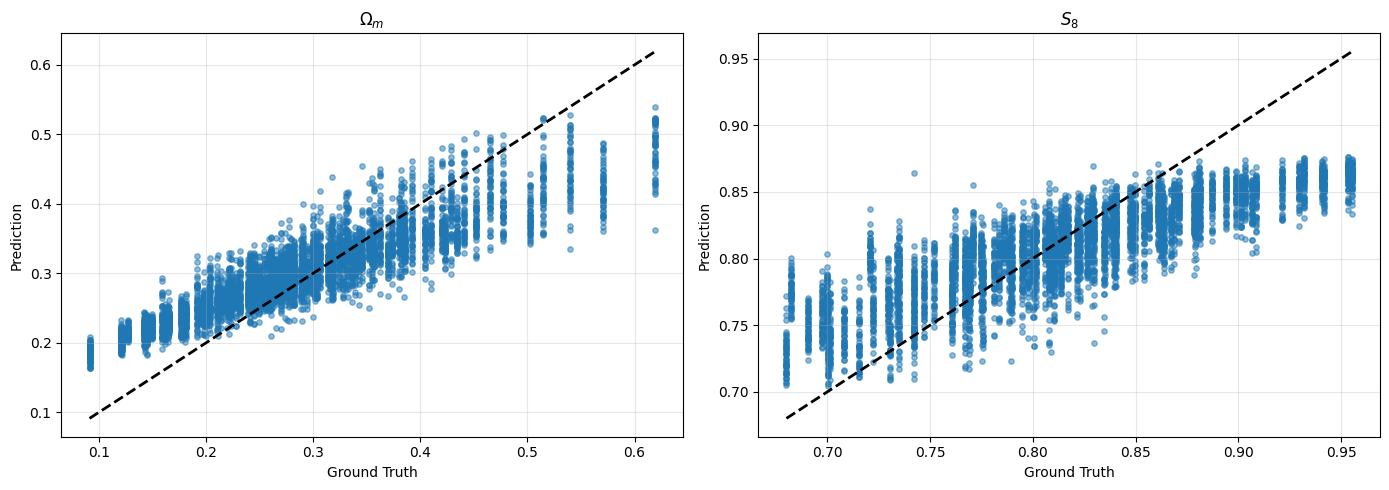

Ωₘ - MSE: 0.003171, R²: 0.7153
S₈ - MSE: 0.001712, R²: 0.6069


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_val[:,0], y_pred_val[:,0], alpha=0.5, s=15)
axes[0].plot(sorted(y_val[:,0]), sorted(y_val[:,0]), 'k--', linewidth=2)
axes[0].set_xlabel('Ground Truth')
axes[0].set_ylabel('Prediction')
axes[0].set_title(r'$\Omega_m$')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_val[:,1], y_pred_val[:,1], alpha=0.5, s=15)
axes[1].plot(sorted(y_val[:,1]), sorted(y_val[:,1]), 'k--', linewidth=2)
axes[1].set_xlabel('Ground Truth')
axes[1].set_ylabel('Prediction')
axes[1].set_title(r'$S_8$')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mse_om = mean_squared_error(y_val[:,0], y_pred_val[:,0])
mse_s8 = mean_squared_error(y_val[:,1], y_pred_val[:,1])
r2_om = r2_score(y_val[:,0], y_pred_val[:,0])
r2_s8 = r2_score(y_val[:,1], y_pred_val[:,1])

print(f"Ωₘ - MSE: {mse_om:.6f}, R²: {r2_om:.4f}")
print(f"S₈ - MSE: {mse_s8:.6f}, R²: {r2_s8:.4f}")

In [18]:
cosmology = data_obj.label[:,0,:2]
Ncosmo = data_obj.Ncosmo

row_to_i = {tuple(cosmology[i]): i for i in range(Ncosmo)}
index_lists = [[] for _ in range(Ncosmo)]

for idx in range(len(y_val)):
    row_tuple = tuple(y_val[idx])
    i = row_to_i[row_tuple]
    index_lists[i].append(idx)

val_cosmology_idx = [np.array(lst) for lst in index_lists]

d_vector = []
n_d = 2

for i in range(Ncosmo):
    d_i = np.zeros((len(val_cosmology_idx[i]), n_d))
    for j, idx in enumerate(val_cosmology_idx[i]):
        d_i[j] = y_pred_val[idx]
    d_vector.append(d_i)

mean_d_vector = np.array([np.mean(d_vector[i], 0) for i in range(Ncosmo)])
delta = [d_vector[i] - mean_d_vector[i].reshape(1, n_d) for i in range(Ncosmo)]
cov_d_vector = np.concatenate([(delta[i].T @ delta[i] / (len(delta[i])-n_d-2))[None] 
                                for i in range(Ncosmo)], 0)

mean_d_vector_interp = LinearNDInterpolator(cosmology, mean_d_vector, fill_value=np.nan)
cov_d_vector_interp = LinearNDInterpolator(cosmology, cov_d_vector, fill_value=np.nan)
logprior_interp = LinearNDInterpolator(cosmology, np.zeros((Ncosmo, 1)), fill_value=-np.inf)

def log_prior(x):
    return logprior_interp(x).flatten()

def loglike(x, d):
    mean = mean_d_vector_interp(x)
    cov = cov_d_vector_interp(x)
    delta = d - mean
    inv_cov = np.linalg.inv(cov)
    cov_det = np.linalg.slogdet(cov)[1]
    return -0.5 * cov_det - 0.5 * np.einsum("ni,nij,nj->n", delta, inv_cov, delta)

def logp_posterior(x, d):
    logp = log_prior(x)
    select = np.isfinite(logp)
    if np.sum(select) > 0:
        logp[select] = logp[select] + loglike(x[select], d[select])
    return logp

print("MCMC setup complete")

MCMC setup complete


In [19]:
Nstep = 10000
sigma = 0.06

current = cosmology[np.random.choice(Ncosmo, size=Nval)]
curr_logprob = logp_posterior(current, y_pred_val)

states = []
total_acc = np.zeros(len(current))

print("Running MCMC on validation set...")

for i in tqdm(range(Nstep), desc="MCMC"):
    proposal = current + np.random.randn(*current.shape) * sigma
    proposal_logprob = logp_posterior(proposal, y_pred_val)
    
    acc_logprob = proposal_logprob - curr_logprob
    acc_logprob[acc_logprob > 0] = 0
    acc_prob = np.exp(acc_logprob)
    acc = np.random.uniform(size=len(current)) < acc_prob
    
    total_acc += acc_prob
    current[acc] = proposal[acc]
    curr_logprob[acc] = proposal_logprob[acc]
    states.append(np.copy(current)[None])

states = np.concatenate(states[int(0.2*Nstep):], 0)
mean_val = np.mean(states, 0)
errorbar_val = np.std(states, 0)

print(f"MCMC complete! Acceptance rate: {np.mean(total_acc/Nstep):.3f}")
print(f"Mean error bars: {np.mean(errorbar_val, 0)}")

Running MCMC on validation set...


MCMC: 100%|██████████| 10000/10000 [00:48<00:00, 207.63it/s]


MCMC complete! Acceptance rate: 0.297
Mean error bars: [0.04300495 0.03079467]


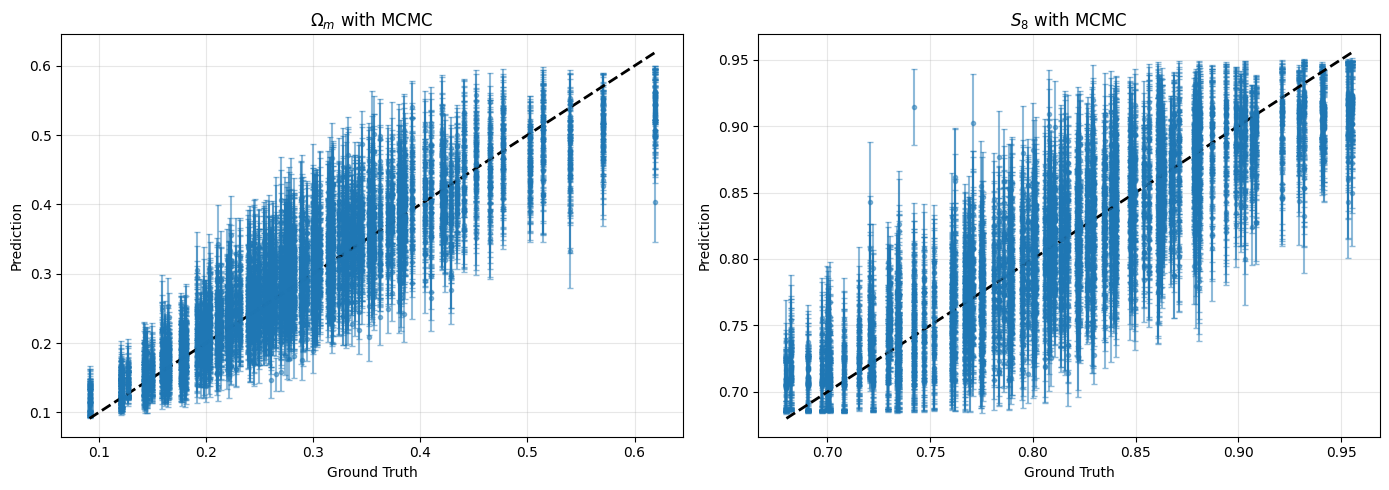


Validation Score: 8.63
Error bar (Ωₘ): 0.043005
Error bar (S₈): 0.030795


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].errorbar(y_val[:,0], mean_val[:,0], yerr=errorbar_val[:,0],
                 fmt='o', capsize=2, alpha=0.5, markersize=3)
axes[0].plot(sorted(y_val[:,0]), sorted(y_val[:,0]), 'k--', linewidth=2)
axes[0].set_xlabel('Ground Truth')
axes[0].set_ylabel('Prediction')
axes[0].set_title(r'$\Omega_m$ with MCMC')
axes[0].grid(True, alpha=0.3)

axes[1].errorbar(y_val[:,1], mean_val[:,1], yerr=errorbar_val[:,1],
                 fmt='o', capsize=2, alpha=0.5, markersize=3)
axes[1].plot(sorted(y_val[:,1]), sorted(y_val[:,1]), 'k--', linewidth=2)
axes[1].set_xlabel('Ground Truth')
axes[1].set_ylabel('Prediction')
axes[1].set_title(r'$S_8$ with MCMC')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

validation_score = Score._score_phase1(y_val, mean_val, errorbar_val)
print(f"\nValidation Score: {validation_score:.2f}")
print(f"Error bar (Ωₘ): {np.mean(errorbar_val[:, 0]):.6f}")
print(f"Error bar (S₈): {np.mean(errorbar_val[:, 1]):.6f}")

In [21]:
print("Predicting on test set...")
y_pred_test = ensemble.predict(test_loader)
y_pred_test = label_scaler.inverse_transform(y_pred_test)

print(f"Test predictions: {y_pred_test.shape}")

Predicting on test set...
Extracting test features...


Extracting CNN features: 100%|██████████| 125/125 [00:16<00:00,  7.65it/s]



Computing statistical features...
Making XGBoost predictions...
Making CNN predictions...
Making XGBoost predictions...
Making CNN predictions...
Combining predictions with meta-learner...
Test predictions: (4000, 2)
Combining predictions with meta-learner...
Test predictions: (4000, 2)


In [22]:
Nstep_test = 10000
sigma_test = 0.06

current_test = cosmology[np.random.choice(Ncosmo, size=data_obj.Ntest)]
curr_logprob_test = logp_posterior(current_test, y_pred_test)

states_test = []
total_acc_test = np.zeros(len(current_test))

print("Running MCMC on test set...")

for i in tqdm(range(Nstep_test), desc="MCMC Test"):
    proposal = current_test + np.random.randn(*current_test.shape) * sigma_test
    proposal_logprob = logp_posterior(proposal, y_pred_test)
    
    acc_logprob = proposal_logprob - curr_logprob_test
    acc_logprob[acc_logprob > 0] = 0
    acc_prob = np.exp(acc_logprob)
    acc = np.random.uniform(size=len(current_test)) < acc_prob
    
    total_acc_test += acc_prob
    current_test[acc] = proposal[acc]
    curr_logprob_test[acc] = proposal_logprob[acc]
    states_test.append(np.copy(current_test)[None])

states_test = np.concatenate(states_test[int(0.2*Nstep_test):], 0)
mean_test = np.mean(states_test, 0)
errorbar_test = np.std(states_test, 0)

print(f"MCMC complete! Acceptance rate: {np.mean(total_acc_test/Nstep_test):.3f}")
print(f"Mean error bars: {np.mean(errorbar_test, 0)}")

Running MCMC on test set...


MCMC Test: 100%|██████████| 10000/10000 [00:43<00:00, 232.13it/s]


MCMC complete! Acceptance rate: 0.297
Mean error bars: [0.04307045 0.03075515]


In [23]:
data_submission = {
    "means": mean_test.tolist(),
    "errorbars": errorbar_test.tolist()
}

timestamp = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
zip_file_name = f'Submission_ConvViT_{timestamp}.zip'

zip_file = Utility.save_json_zip(
    submission_dir="submissions",
    json_file_name="result.json",
    zip_file_name=zip_file_name,
    data=data_submission
)

print("=" * 70)
print("SUBMISSION CREATED")
print("=" * 70)
print(f"File: {zip_file}")
print(f"Test samples: {len(mean_test)}")
print("=" * 70)

SUBMISSION CREATED
File: submissions/Submission_ConvViT_25-11-11-19-52.zip
Test samples: 4000
